# Analysis of Overlapping Bounding Boxes & Annotation Format

This notebook analyzes YOLO annotation files in the annotation data folder to:
1. **Format analysis:** Count how often each annotation format (toy, drawing, photo, real, video) appears and which object categories co-occur with each format.
2. **Montages (Section 5b):** For each format, build a montage of exemplar object crops from images that have that format → saved to `figures/format_montages/`.
3. **Overlap analysis:** Find bounding boxes that overlap (IoU ≥ threshold), summarize by object type pair and by category pair.

**Input:** YOLO-style `.txt` files (one per image) with lines `class_id x_center y_center width height` (normalized 0–1), and an `obj.names` file listing class names (including format classes: `*_format`).

## 1. Paths and configuration

In [1]:
import os
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Base directory: folder containing annotation_data/. Run notebook from annotation/ or set accordingly.
ANNOTATION_BASE = Path(".").resolve()
if not (ANNOTATION_BASE / "annotation_data").exists():
    # If run from project root
    ANNOTATION_BASE = ANNOTATION_BASE / "annotation"
if not (ANNOTATION_BASE / "annotation_data").exists():
    raise FileNotFoundError("annotation_data/ not found. Run from annotation/ or set ANNOTATION_BASE.")

# Pick one completed VEDI dataset (subfolder of annotation_data with obj.names and obj_train_data)
DATASET_NAME = "Mira_20251112_completed_edited_VEDI"  # or e.g. Dora_20251112_completed_VEDI, Mira_20251001_completed_edited_VEDI
dataset_dir = ANNOTATION_BASE / "annotation_data" / DATASET_NAME
obj_names_file = dataset_dir / "obj.names"
obj_train_data_dir = dataset_dir / "obj_train_data"

# Find the actual folder of .txt annotation files (may be nested, e.g. obj_train_data/Mira_groundtruth_20251112/)
txt_dirs = list(obj_train_data_dir.rglob("*.txt"))
if txt_dirs:
    ann_dir = txt_dirs[0].parent
else:
    ann_dir = obj_train_data_dir
ann_files = list(ann_dir.glob("*.txt"))

print("Dataset:", dataset_dir)
print("obj.names:", obj_names_file.exists())
print("Annotation .txt count:", len(ann_files))

Dataset: /home/j7yang/babyview-projects/vss2026/object-detection/annotation/annotation_data/Mira_20251112_completed_edited_VEDI
obj.names: True
Annotation .txt count: 77


## 2. Load class names

In [2]:
with open(obj_names_file, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

print(f"Total classes: {len(class_names)}")
print(f"First 10: {class_names[:10]}")
print(f"Last 10: {class_names[-10:]}")

class_dict = {i: name for i, name in enumerate(class_names)}
format_suffix = "_format"
format_classes = [c for c in class_names if c.endswith(format_suffix)]
print(f"Format classes: {format_classes}")

Total classes: 300
First 10: ['airplane', 'alligator', 'animal', 'ankle', 'ant', 'apple', 'applesauce', 'arm', 'ball', 'balloon']
Last 10: ['wolf', 'yard', 'yogurt', 'zebra', 'zipper', 'drawing_format', 'toy_format', 'photo_format', 'video_format', 'real_format']
Format classes: ['drawing_format', 'toy_format', 'photo_format', 'video_format', 'real_format']


## 3. Parse annotation files and classify boxes

In [3]:
def parse_yolo_line(line, class_dict):
    """Parse one line: class_id x_center y_center width height (normalized). Return (class_id, class_name, bbox as x1,y1,x2,y2)."""
    parts = line.strip().split()
    if len(parts) < 5:
        return None
    cid = int(parts[0])
    xc, yc, w, h = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
    x1 = xc - w / 2
    y1 = yc - h / 2
    x2 = xc + w / 2
    y2 = yc + h / 2
    name = class_dict.get(cid, "unknown")
    return (cid, name, (x1, y1, x2, y2))

def get_object_type(class_name, format_classes):
    if class_name == "picture":
        return "picture"
    if class_name == "toy":
        return "toy"
    if class_name in format_classes or class_name.endswith("_format"):
        return "real_life"  # format boxes treated as real_life for type-pair stats
    return "real_life"

all_boxes_by_image = []
for ann_file in ann_files:
    boxes = []
    with open(ann_file, "r") as f:
        for line in f:
            parsed = parse_yolo_line(line, class_dict)
            if parsed is None:
                continue
            cid, cname, bbox = parsed
            obj_type = get_object_type(cname, format_classes)
            boxes.append({"class_id": cid, "class_name": cname, "bbox": bbox, "object_type": obj_type})
    all_boxes_by_image.append((ann_file, boxes))

print(f"Loaded {sum(len(b) for _, b in all_boxes_by_image)} boxes from {len(all_boxes_by_image)} images.")

Loaded 1074 boxes from 77 images.


## 4. Double annotations: count format types and category×format pairs

In [4]:
format_counts = defaultdict(int)
category_format_pairs = defaultdict(int)
double_format_counts = []
double_category_counts = []

for ann_file, boxes in all_boxes_by_image:
    format_boxes = [b for b in boxes if b["class_name"] in format_classes]
    category_boxes = [b for b in boxes if b["class_name"] not in format_classes]
    if not format_boxes or not category_boxes:
        continue
    double_format_counts.append(len(format_boxes))
    double_category_counts.append(len(category_boxes))
    for b in format_boxes:
        format_counts[b["class_name"]] += 1
    for cat_b in category_boxes:
        for fmt_b in format_boxes:
            key = (cat_b["class_name"], fmt_b["class_name"])
            category_format_pairs[key] += 1

print("Format counts (in double-annotation images):")
for name in sorted(format_counts.keys()):
    print(f"  {name}: {format_counts[name]}")
print(f"\nImages with both category and format boxes: {len(double_format_counts)}")
print(f"Total format boxes in those images: {sum(double_format_counts)}")
print(f"Total category×format pairs: {sum(c * f for c, f in zip(double_category_counts, double_format_counts))}")

Format counts (in double-annotation images):
  drawing_format: 11
  photo_format: 15
  real_format: 483
  toy_format: 9
  video_format: 1

Images with both category and format boxes: 67
Total format boxes in those images: 519
Total category×format pairs: 6068


## 5. Visualizations: format proportion (pie) and top categories per format (bar charts)

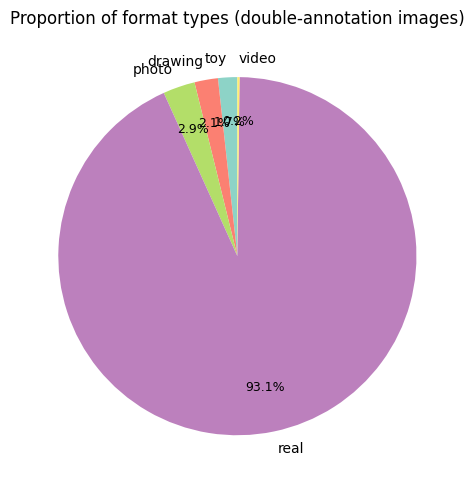

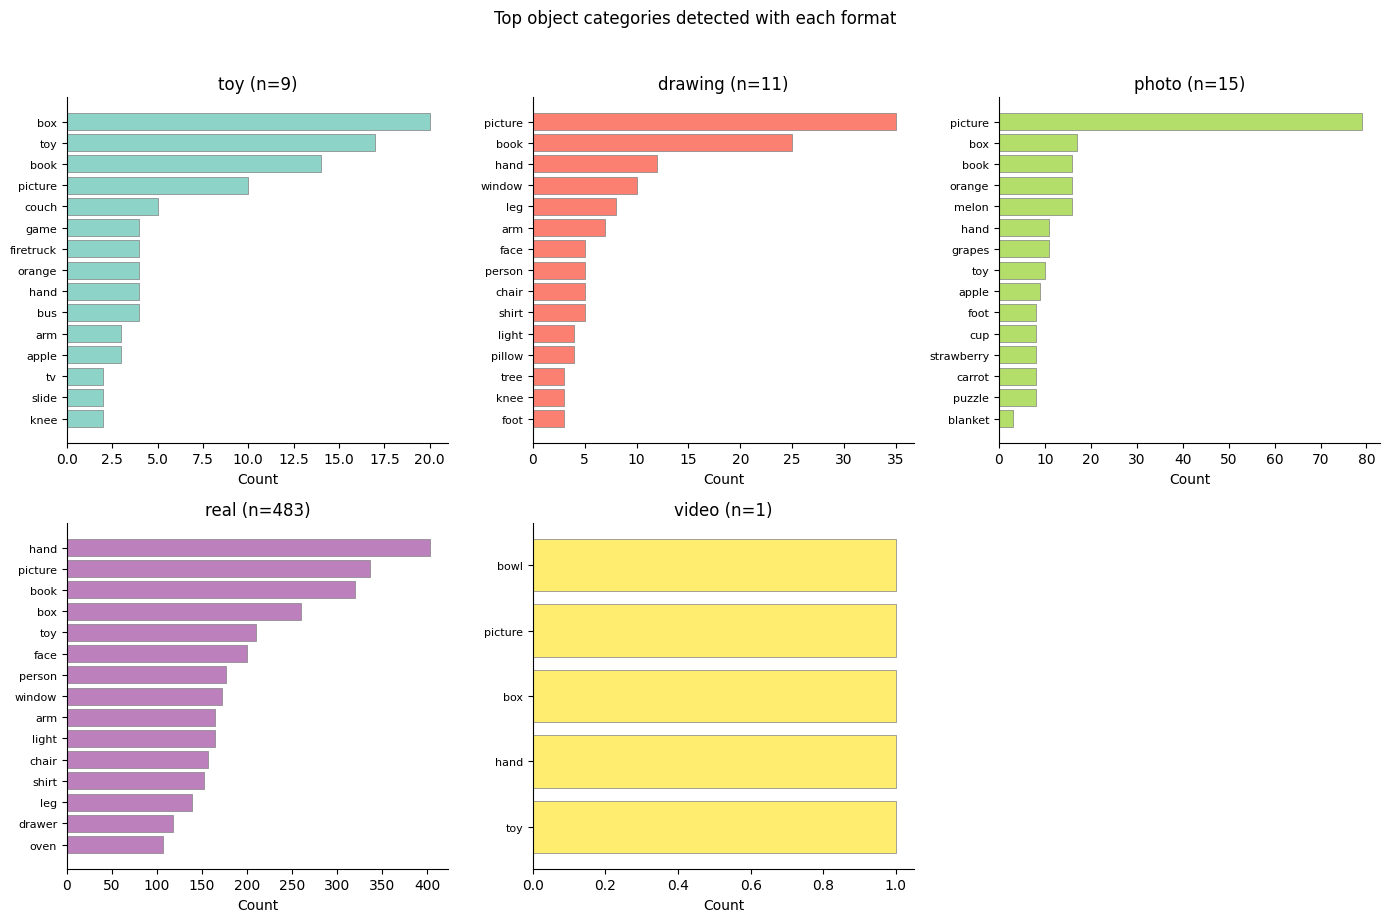

Saved: figures/format_proportion_pie.png, figures/format_top_categories_bars.png


In [5]:
import os
os.makedirs("figures", exist_ok=True)

format_types_ordered = ["toy_format", "drawing_format", "photo_format", "real_format", "video_format"]
counts = [format_counts.get(fmt, 0) for fmt in format_types_ordered]
total_format_boxes = sum(format_counts.values())

fig, ax = plt.subplots(figsize=(6, 5))
if total_format_boxes == 0:
    ax.text(0.5, 0.5, "No format data", ha="center", va="center", fontsize=14, transform=ax.transAxes)
    ax.set_title("Proportion of format types (double-annotation images)")
else:
    filtered = [(fmt, c) for fmt, c in zip(format_types_ordered, counts) if c > 0]
    if not filtered:
        ax.text(0.5, 0.5, "No format data", ha="center", va="center", fontsize=14, transform=ax.transAxes)
    else:
        fts, cnts = zip(*filtered)
        labels = [fmt.replace("_format", "") for fmt in fts]
        colors = plt.cm.Set3(np.linspace(0, 1, len(fts)))
        wedges, texts, autotexts = ax.pie(cnts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, pctdistance=0.75)
        for t in autotexts:
            t.set_fontsize(9)
    ax.set_title("Proportion of format types (double-annotation images)")
plt.tight_layout()
fig.savefig("figures/format_proportion_pie.png", dpi=150, bbox_inches="tight")
plt.show()

# Per-format bar charts: top object categories per format
n_top = 15
colors = plt.cm.Set3(np.linspace(0, 1, len(format_types_ordered)))
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()
for idx, fmt in enumerate(format_types_ordered):
    ax = axes[idx]
    cat_counts = [(cat, c) for (cat, f), c in category_format_pairs.items() if f == fmt]
    cat_counts.sort(key=lambda x: -x[1])
    top = cat_counts[:n_top]
    if not top:
        ax.text(0.5, 0.5, f"No data for {fmt}", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(fmt.replace("_format", ""))
        ax.set_axis_off()
        continue
    cats = [x[0] for x in top]
    cnts = [x[1] for x in top]
    y_pos = np.arange(len(cats))[::-1]
    ax.barh(y_pos, cnts, color=colors[idx], edgecolor="gray", linewidth=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cats, fontsize=8)
    ax.set_xlabel("Count")
    ax.set_title(f"{fmt.replace('_format', '')} (n={format_counts.get(fmt, 0)})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
fig.delaxes(axes[5])
plt.suptitle("Top object categories detected with each format", fontsize=12, y=1.02)
plt.tight_layout()
fig.savefig("figures/format_top_categories_bars.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: figures/format_proportion_pie.png, figures/format_top_categories_bars.png")

## 6. Overlap analysis: IoU and stats

In [6]:
def calculate_iou(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)
    inter_w = max(0, xi2 - xi1)
    inter_h = max(0, yi2 - yi1)
    inter = inter_w * inter_h
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0.0

iou_threshold = 0.5
stats = {
    "total_images": 0,
    "total_boxes": 0,
    "images_with_overlaps": 0,
    "total_overlaps": 0,
    "overlaps_by_type": defaultdict(int),
    "category_pairs": defaultdict(int),
}
overlaps = []

for ann_file, boxes in all_boxes_by_image:
    stats["total_images"] += 1
    stats["total_boxes"] += len(boxes)
    image_has_overlap = False
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            iou = calculate_iou(boxes[i]["bbox"], boxes[j]["bbox"])
            if iou >= iou_threshold:
                image_has_overlap = True
                stats["total_overlaps"] += 1
                type_pair = tuple(sorted([boxes[i]["object_type"], boxes[j]["object_type"]]))
                stats["overlaps_by_type"][type_pair] += 1
                cat_pair = tuple(sorted([boxes[i]["class_name"], boxes[j]["class_name"]]))
                stats["category_pairs"][cat_pair] += 1
                overlaps.append({
                    "image_file": ann_file.name,
                    "box1_class_name": boxes[i]["class_name"], "box1_object_type": boxes[i]["object_type"], "box1_bbox": boxes[i]["bbox"],
                    "box2_class_name": boxes[j]["class_name"], "box2_object_type": boxes[j]["object_type"], "box2_bbox": boxes[j]["bbox"],
                    "iou": iou,
                })
    if image_has_overlap:
        stats["images_with_overlaps"] += 1

print("Total images:", stats["total_images"])
print("Total boxes:", stats["total_boxes"])
print("Images with overlaps:", stats["images_with_overlaps"])
print("Total overlapping pairs:", stats["total_overlaps"])

Total images: 77
Total boxes: 1074
Images with overlaps: 67
Total overlapping pairs: 653


## 7. Overlaps by object type (bar chart)

Overlaps by Object Type Pair:
            Type Pair  Count
real_life + real_life    549
  picture + real_life     70
      real_life + toy     34


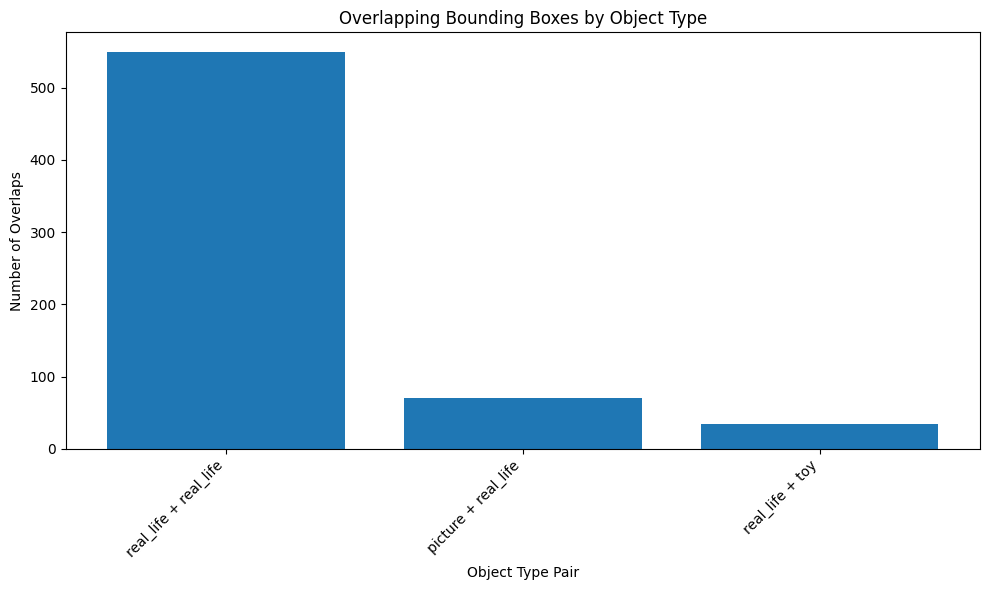

Saved: figures/overlaps_by_object_type.png


In [7]:
overlaps_by_type_df = pd.DataFrame([
    {"Type Pair": f"{p[0]} + {p[1]}", "Count": c}
    for p, c in sorted(stats["overlaps_by_type"].items(), key=lambda x: -x[1])
])
print("Overlaps by Object Type Pair:")
print(overlaps_by_type_df.to_string(index=False))

if len(overlaps_by_type_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.bar(overlaps_by_type_df["Type Pair"], overlaps_by_type_df["Count"])
    plt.xlabel("Object Type Pair")
    plt.ylabel("Number of Overlaps")
    plt.title("Overlapping Bounding Boxes by Object Type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("figures/overlaps_by_object_type.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: figures/overlaps_by_object_type.png")

## 8. Top category pairs in overlaps (bar chart)

Top 20 Most Common Category Pairs in Overlaps:
    Category 1  Category 2  Count
          hand real_format     43
          book real_format     32
           box real_format     26
          face real_format     20
        person real_format     20
   real_format      window     17
   real_format         toy     16
   real_format       shirt     16
         chair real_format     16
   real_format real_format     15
  photo_format     picture     15
         light real_format     15
          oven real_format     13
       picture real_format     13
          door real_format     12
        drawer real_format     12
   real_format     sweater     11
           arm real_format     11
drawing_format     picture     11
           leg real_format     10


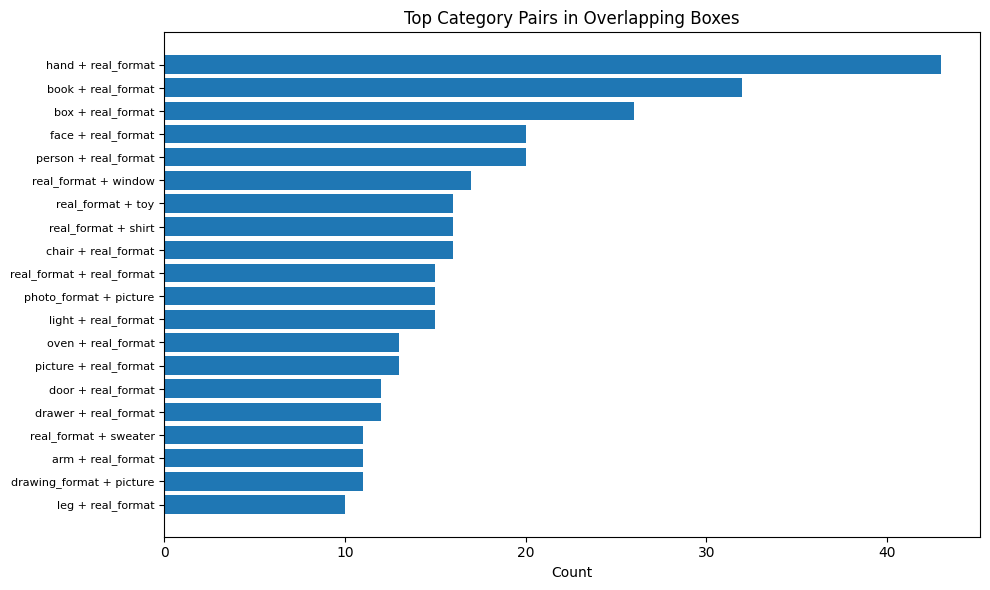

Saved: figures/overlaps_by_category_pairs.png


In [8]:
top_category_pairs = sorted(stats["category_pairs"].items(), key=lambda x: -x[1])[:20]
category_pairs_df = pd.DataFrame([
    {"Category 1": p[0], "Category 2": p[1], "Count": c} for p, c in top_category_pairs
])
print("Top 20 Most Common Category Pairs in Overlaps:")
print(category_pairs_df.to_string(index=False))

if len(category_pairs_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(category_pairs_df)), category_pairs_df["Count"])
    plt.yticks(range(len(category_pairs_df)), [f"{r['Category 1']} + {r['Category 2']}" for _, r in category_pairs_df.iterrows()], fontsize=8)
    plt.xlabel("Count")
    plt.title("Top Category Pairs in Overlapping Boxes")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("figures/overlaps_by_category_pairs.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved: figures/overlaps_by_category_pairs.png")